# Project - Fights Prediction

## Name: Muwei (Luke) Gu

### Part 1: Preparation and set up our data frame

First, let's import our packages and load the data.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
airlines = pd.read_csv("airlines.csv")
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [4]:
airports = pd.read_csv("airports.csv")
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
flights = pd.read_csv("flights.csv",low_memory=False)
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


We need to combine the three different files based on the iata_code.

In [6]:
%%time
df = pd.merge(flights,airlines,left_on='AIRLINE',right_on='IATA_CODE')
df['AIRLINE_x'] = df['AIRLINE_y']
df = df.drop(columns=['IATA_CODE','AIRLINE_y'])
df.rename(columns={'AIRLINE_x': 'AIRLINE'}, inplace=True)
df = pd.merge(df,airports,left_on='ORIGIN_AIRPORT',right_on='IATA_CODE')
df['ORIGIN_AIRPORT'] = df['AIRPORT']
df = df.drop(columns=['IATA_CODE','AIRPORT'])
df.rename(columns={'CITY': 'ORIGIN_CITY','STATE':'ORIGIN_STATE','COUNTRY':'ORIGIN_COUNTRY','LATITUDE':'ORIGIN_LATITUDE','LONGITUDE':'ORIGIN_LONGITUDE'}, inplace=True)
df = pd.merge(df,airports,left_on='DESTINATION_AIRPORT',right_on='IATA_CODE')
df['DESTINATION_AIRPORT'] = df['AIRPORT']
df = df.drop(columns=['IATA_CODE','AIRPORT'])
df.rename(columns={'CITY': 'DESTINATION_CITY','STATE':'DESTINATION_STATE','COUNTRY':'DESTINATION_COUNTRY','LATITUDE':'DESTINATION_LATITUDE','LONGITUDE':'DESTINATION_LONGITUDE'}, inplace=True)
df.head()

CPU times: user 48.5 s, sys: 20.5 s, total: 1min 8s
Wall time: 55.5 s


It looks like we have a lot of data to deal with and before we start with our exploration, we have to pick those columns we need and related to flight delays.

In [7]:
df.dtypes

YEAR                       int64
MONTH                      int64
DAY                        int64
DAY_OF_WEEK                int64
AIRLINE                   object
FLIGHT_NUMBER              int64
TAIL_NUMBER               object
ORIGIN_AIRPORT            object
DESTINATION_AIRPORT       object
SCHEDULED_DEPARTURE        int64
DEPARTURE_TIME           float64
DEPARTURE_DELAY          float64
TAXI_OUT                 float64
WHEELS_OFF               float64
SCHEDULED_TIME           float64
ELAPSED_TIME             float64
AIR_TIME                 float64
DISTANCE                   int64
WHEELS_ON                float64
TAXI_IN                  float64
SCHEDULED_ARRIVAL          int64
ARRIVAL_TIME             float64
ARRIVAL_DELAY            float64
DIVERTED                   int64
CANCELLED                  int64
CANCELLATION_REASON       object
AIR_SYSTEM_DELAY         float64
SECURITY_DELAY           float64
AIRLINE_DELAY            float64
LATE_AIRCRAFT_DELAY      float64
WEATHER_DE

In [8]:
df = df.drop(['FLIGHT_NUMBER','TAIL_NUMBER','YEAR','ORIGIN_STATE','ORIGIN_COUNTRY','ORIGIN_LATITUDE','ORIGIN_LONGITUDE',
              'DESTINATION_STATE','DESTINATION_COUNTRY','DESTINATION_LATITUDE','DESTINATION_LONGITUDE'],axis=1)
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_CITY,DESTINATION_CITY
0,1,1,4,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,5,2354.0,-11.0,21.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Anchorage,Seattle
1,1,1,4,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,45,41.0,-4.0,17.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Anchorage,Seattle
2,1,1,4,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,135,NaN,NaN,NaN,...,0,1,A,NaN,NaN,NaN,NaN,NaN,Anchorage,Seattle
3,1,1,4,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,155,140.0,-15.0,17.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Anchorage,Seattle
4,1,1,4,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,220,209.0,-11.0,15.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Anchorage,Seattle


Everything looks fine, we can proceed to the exploration now.

### Part 2: Explore on airlines

In this part, we need to find out anything related to different airline companies and categorize them. Let's summerize airlines and see how many of them contained in our data set.

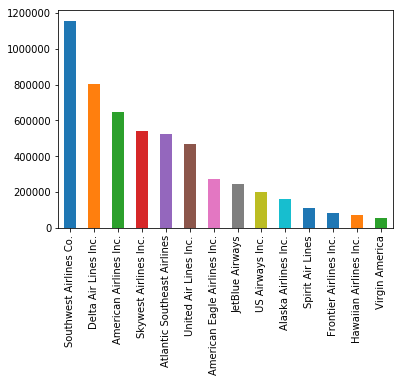

In [9]:
pd.value_counts(df['AIRLINE']).plot.bar()

We can separate them based on the departure delays and the arrival delays. However, it seems that there are not many differences after all.

In [10]:
df.groupby(['AIRLINE'])['DEPARTURE_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
AIRLINE,,,,,,,,
Alaska Airlines Inc.,157472.0,1.957637,26.756482,-82.0,-8.0,-4.0,1.0,963.0
American Airlines Inc.,639002.0,9.330882,42.672433,-68.0,-5.0,-2.0,6.0,1988.0
American Eagle Airlines Inc.,258555.0,10.685483,40.609667,-36.0,-6.0,-2.0,9.0,1278.0
Atlantic Southeast Airlines,512032.0,9.076964,39.165995,-55.0,-6.0,-3.0,5.0,1274.0
Delta Air Lines Inc.,796638.0,7.763099,37.027116,-61.0,-4.0,-1.0,4.0,1289.0
Frontier Airlines Inc.,82201.0,14.267977,50.956785,-46.0,-7.0,-2.0,13.0,1112.0
Hawaiian Airlines Inc.,69889.0,0.514001,24.628946,-27.0,-7.0,-4.0,1.0,1433.0
JetBlue Airways,241056.0,11.828654,39.156646,-31.0,-6.0,-2.0,11.0,1006.0
Skywest Airlines Inc.,530501.0,8.181225,38.257122,-56.0,-6.0,-3.0,4.0,1378.0


In [11]:
df.groupby(['AIRLINE'])['ARRIVAL_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
AIRLINE,,,,,,,,
Alaska Airlines Inc.,157025.0,-0.791409,29.018948,-82.0,-14.0,-5.0,4.0,950.0
American Airlines Inc.,636554.0,3.935214,45.015492,-87.0,-15.0,-6.0,8.0,1971.0
American Eagle Airlines Inc.,257130.0,7.316540,44.535512,-63.0,-14.0,-5.0,12.0,1272.0
Atlantic Southeast Airlines,509621.0,6.964550,41.189887,-64.0,-12.0,-4.0,9.0,1223.0
Delta Air Lines Inc.,794817.0,0.680265,39.166200,-79.0,-15.0,-7.0,3.0,1274.0
Frontier Airlines Inc.,82005.0,13.729468,52.976344,-73.0,-11.0,-1.0,17.0,1101.0
Hawaiian Airlines Inc.,69815.0,2.161856,25.787022,-67.0,-6.0,-2.0,5.0,1467.0
JetBlue Airways,240304.0,6.949339,42.039092,-76.0,-15.0,-5.0,12.0,1002.0
Skywest Airlines Inc.,528328.0,6.221438,39.747253,-69.0,-12.0,-4.0,8.0,1372.0


We can plot a stacked bar plot to visualize the delays based on departure and arrival. From the graph, we can clearly see that some companies rarely have delayed airlines and some airlines like delta really does a great job to make their flights to arrive on time even though they might departure late, since there is a huge gap between the mean of  departure delays and that of arrival delays.

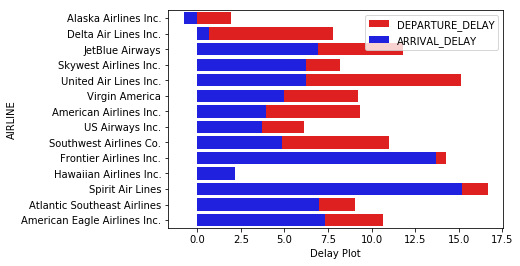

In [12]:
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="red", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="blue", ci=None)
plt.xlabel("Delay Plot")
plt.legend(['DEPARTURE_DELAY','ARRIVAL_DELAY'])

### Part 3: Explore more on airports

First of all in this part, how many airports do we have in our dataset? This should be easy to find out! Aha, it is greate that the numbers are the same in origins and destinations. At the same time, we can also find out each airline company operates flights between how many airports.

In [13]:
print(len(df['ORIGIN_AIRPORT'].unique()))
print(len(df['DESTINATION_AIRPORT'].unique()))

322
322


In [14]:
group = df.groupby(['AIRLINE'])
for air_company in group.groups.keys():
    num = len(df.loc[df['AIRLINE'] == air_company]['ORIGIN_AIRPORT'].unique())
    print(air_company,":",num)
    

Alaska Airlines Inc. : 67
American Airlines Inc. : 98
American Eagle Airlines Inc. : 133
Atlantic Southeast Airlines : 181
Delta Air Lines Inc. : 156
Frontier Airlines Inc. : 63
Hawaiian Airlines Inc. : 17
JetBlue Airways : 64
Skywest Airlines Inc. : 211
Southwest Airlines Co. : 86
Spirit Air Lines : 34
US Airways Inc. : 79
United Air Lines Inc. : 94
Virgin America : 21


In [15]:
group = df.groupby(['AIRLINE'])
for air_company in group.groups.keys():
    num = len(df.loc[df['AIRLINE'] == air_company]['DESTINATION_AIRPORT'].unique())
    print(air_company,":",num)

Alaska Airlines Inc. : 67
American Airlines Inc. : 98
American Eagle Airlines Inc. : 133
Atlantic Southeast Airlines : 183
Delta Air Lines Inc. : 156
Frontier Airlines Inc. : 63
Hawaiian Airlines Inc. : 17
JetBlue Airways : 64
Skywest Airlines Inc. : 211
Southwest Airlines Co. : 86
Spirit Air Lines : 34
US Airways Inc. : 79
United Air Lines Inc. : 94
Virgin America : 20


Now, Let's make some pivot tables for airlines and the top 10 origin airports to see more details!

In [16]:
df['ORIGIN_AIRPORT'].value_counts().nlargest(10).keys()

Index(['Hartsfield-Jackson Atlanta International Airport',
       'Chicago O'Hare International Airport',
       'Dallas/Fort Worth International Airport',
       'Denver International Airport', 'Los Angeles International Airport',
       'San Francisco International Airport',
       'Phoenix Sky Harbor International Airport',
       'George Bush Intercontinental Airport',
       'McCarran International Airport',
       'Minneapolis-Saint Paul International Airport'],
      dtype='object')

In [17]:
df['DESTINATION_AIRPORT'].value_counts().nlargest(10).keys()

Index(['Hartsfield-Jackson Atlanta International Airport',
       'Chicago O'Hare International Airport',
       'Dallas/Fort Worth International Airport',
       'Denver International Airport', 'Los Angeles International Airport',
       'San Francisco International Airport',
       'Phoenix Sky Harbor International Airport',
       'George Bush Intercontinental Airport',
       'McCarran International Airport',
       'Minneapolis-Saint Paul International Airport'],
      dtype='object')

In [18]:
list = ['Hartsfield-Jackson Atlanta International Airport',
       'Chicago O\'Hare International Airport',
       'Dallas/Fort Worth International Airport',
       'Denver International Airport', 'Los Angeles International Airport',
       'Phoenix Sky Harbor International Airport',
       'San Francisco International Airport',
       'George Bush Intercontinental Airport',
       'McCarran International Airport',
       'Minneapolis-Saint Paul International Airport']
df2 = df.loc[df['ORIGIN_AIRPORT'].isin(list)]
df2.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_CITY,DESTINATION_CITY
12726,1,1,4,Alaska Airlines Inc.,Los Angeles International Airport,Seattle-Tacoma International Airport,600,555.0,-5.0,21.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,Seattle
12727,1,1,4,Alaska Airlines Inc.,Los Angeles International Airport,Seattle-Tacoma International Airport,700,655.0,-5.0,15.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,Seattle
12728,1,1,4,Alaska Airlines Inc.,Los Angeles International Airport,Seattle-Tacoma International Airport,840,839.0,-1.0,20.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,Seattle
12729,1,1,4,Alaska Airlines Inc.,Los Angeles International Airport,Seattle-Tacoma International Airport,1030,1023.0,-7.0,14.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,Seattle
12730,1,1,4,Alaska Airlines Inc.,Los Angeles International Airport,Seattle-Tacoma International Airport,1300,1422.0,82.0,23.0,...,0,0,NaN,14.0,0.0,0.0,82.0,0.0,Los Angeles,Seattle


In [19]:
pd.pivot_table(df2,values='DEPARTURE_DELAY',index='ORIGIN_AIRPORT',columns='AIRLINE',aggfunc=np.max)

AIRLINE,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
ORIGIN_AIRPORT,,,,,,,,,,,,,,
Chicago O'Hare International Airport,812.0,1258.0,841.0,583.0,1201.0,710.0,NaN,1006.0,694.0,NaN,634.0,487.0,644.0,341.0
Dallas/Fort Worth International Airport,337.0,1377.0,1076.0,677.0,755.0,852.0,NaN,942.0,897.0,NaN,679.0,424.0,555.0,NaN
Denver International Airport,963.0,949.0,NaN,672.0,1125.0,503.0,NaN,308.0,414.0,413.0,449.0,446.0,1194.0,NaN
George Bush Intercontinental Airport,270.0,1205.0,99.0,626.0,989.0,618.0,NaN,NaN,526.0,NaN,476.0,430.0,864.0,NaN
Hartsfield-Jackson Atlanta International Airport,163.0,985.0,860.0,818.0,1087.0,650.0,NaN,NaN,1378.0,422.0,519.0,490.0,428.0,NaN
Los Angeles International Airport,576.0,1492.0,516.0,NaN,1157.0,767.0,1037.0,459.0,893.0,476.0,696.0,439.0,786.0,406.0
McCarran International Airport,749.0,1604.0,NaN,NaN,944.0,708.0,1103.0,892.0,869.0,620.0,723.0,500.0,753.0,577.0
Minneapolis-Saint Paul International Airport,154.0,1576.0,259.0,1000.0,817.0,996.0,NaN,NaN,878.0,402.0,546.0,352.0,563.0,NaN
Phoenix Sky Harbor International Airport,352.0,1367.0,NaN,15.0,898.0,629.0,203.0,246.0,594.0,475.0,295.0,549.0,783.0,NaN


In [20]:
pd.pivot_table(df2,values='DEPARTURE_DELAY',index='ORIGIN_AIRPORT',columns='AIRLINE',aggfunc=np.median)

AIRLINE,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
ORIGIN_AIRPORT,,,,,,,,,,,,,,
Chicago O'Hare International Airport,-3.0,-1.0,-1.0,-2.0,-1.0,0.0,NaN,-1.0,-1.0,NaN,6.0,-2.0,2.0,0.0
Dallas/Fort Worth International Airport,-4.0,-1.0,-1.0,-1.0,-2.0,-3.0,NaN,0.0,-2.0,NaN,-1.0,-2.0,-2.0,NaN
Denver International Airport,-4.0,-2.0,NaN,-1.0,-1.0,-2.0,NaN,1.0,-1.0,1.0,-1.0,-4.0,2.0,NaN
George Bush Intercontinental Airport,-5.0,-4.0,-1.0,-3.0,-2.0,-1.0,NaN,NaN,-1.0,NaN,3.0,-4.0,3.0,NaN
Hartsfield-Jackson Atlanta International Airport,-1.0,-3.0,-1.0,-2.0,-1.0,0.0,NaN,NaN,-2.0,0.0,4.0,-4.0,2.0,NaN
Los Angeles International Airport,-4.0,-2.0,-1.0,NaN,0.0,-4.0,-4.0,0.0,-2.0,3.0,1.0,-2.0,1.0,-1.0
McCarran International Airport,-7.0,-3.0,NaN,NaN,-2.0,-3.0,-3.0,-1.0,-3.0,1.0,-2.0,-4.0,-2.0,-1.0
Minneapolis-Saint Paul International Airport,-3.0,-3.0,6.0,-1.0,-2.0,-2.0,NaN,NaN,-2.0,-1.0,2.0,-3.0,0.0,NaN
Phoenix Sky Harbor International Airport,-7.0,-2.0,NaN,4.0,-3.0,-2.0,-4.0,4.0,-4.0,2.0,0.0,-2.0,-1.0,NaN


## Part 4: Other Explorations

In [ ]:
Part 4.1

### Part 4.1
After the previous two parts, we have gathered enough information on airlines and airports and even the relationship between them. We can further explore more on the delays itself and even with related to the different time frames during the whole year.

We can make a graph on the different kinds of delays throughout the whole year. Overall speaking, the weather delay is not the most significant delays and airline delays might cause a much longer waiting time and inconvenience.

CPU times: user 30.4 s, sys: 6.7 s, total: 37.1 s
Wall time: 23 s


<Figure size 1800x720 with 0 Axes>

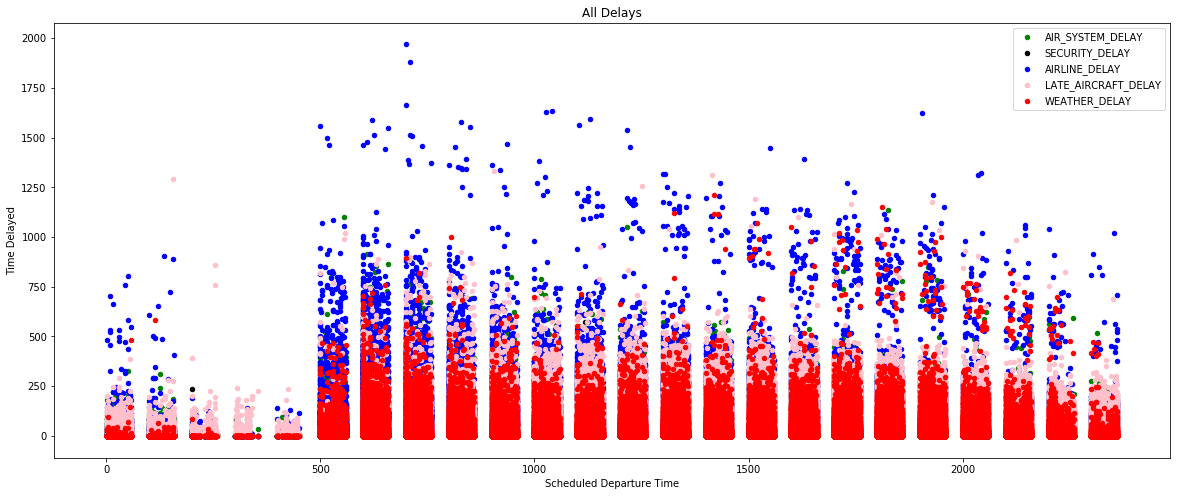

In [21]:
%%time
plt.figure(figsize=(25, 10))
ax1 = df.plot(kind='scatter', x='SCHEDULED_DEPARTURE', y='AIR_SYSTEM_DELAY',figsize=(20,8), color='green')
ax2 = df.plot(kind='scatter', x='SCHEDULED_DEPARTURE', y='SECURITY_DELAY', color='black', ax=ax1)
ax3 = df.plot(kind='scatter', x='SCHEDULED_DEPARTURE', y='AIRLINE_DELAY', color='blue', ax=ax1)
ax4 = df.plot(kind='scatter', x='SCHEDULED_DEPARTURE', y='LATE_AIRCRAFT_DELAY', color='pink', ax=ax1)
ax5 = df.plot(kind='scatter', x='SCHEDULED_DEPARTURE', y='WEATHER_DELAY', color='red', ax=ax1)
ax1.legend(['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY'])
ax1.set_xlabel("Scheduled Departure Time")
ax1.set_ylabel("Time Delayed")
plt.title('All Delays')

### Part 4.2 - Chicago airport case study
Since chicago airport had the most serious delays in Year 2015 and probably almost every year since the bad weather over there during the winter time, we would like to further investigate on this airport to check our more.

Let's make a new data frame called chicago and make a new column on the date.

In [22]:
df['DATE'] = df['MONTH'] + df['DAY']/31
chicago = df.loc[df['ORIGIN_AIRPORT']=='Chicago O\'Hare International Airport']
chicago.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_CITY,DESTINATION_CITY,DATE
72339,1,1,4,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,800,757.0,-3.0,14.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Chicago,Seattle,1.032258
72340,1,1,4,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,1520,1520.0,0.0,21.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Chicago,Seattle,1.032258
72341,1,1,4,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,1930,1934.0,4.0,21.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Chicago,Seattle,1.032258
72342,1,2,5,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,800,814.0,14.0,22.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Chicago,Seattle,1.064516
72343,1,2,5,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,1520,1527.0,7.0,16.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Chicago,Seattle,1.064516


We can visualize the number of delays in chicago airport on each single day and realize the trends of delays.

Obviously, there are more overall delays in winter from December to February which coincidences with our initial estimation.

In [23]:
arr1 = []
arr2 = []
for x in chicago['DATE'].unique():
    temp = chicago.loc[chicago['DATE']==x]
    arr1.append(x)
    arr2.append(temp['DEPARTURE_DELAY'].mean())

In [24]:
plotly.offline.init_notebook_mode(connected=True)
trace = go.Scatter(
    x = arr1,
    y = arr2,
    mode = 'lines'
)
data = [trace]
layout = go.Layout(
    title='Delays in Chicago all year round',
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Departure Delay'
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='delay')


## Part 5: Flight Delay Prediction

Let's do more marchine learning on this data set to see if we could predict airline clusters and also flight delays with given some information. 

### Part 5.1 Cluster airlines in Chicago airport
Now, we should pick the columns which make sense to affect the flights' arrival and also drop those rows with missing data here since we have a large data set already. Since the original data set is too big and takes more than 15 minutes to proceed in later parts, we will still try to use the chicago data frame.

In [31]:
df_final = chicago.copy()
df_final = df_final[['DATE','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','DEPARTURE_DELAY','TAXI_OUT',
               'DISTANCE','TAXI_IN','SCHEDULED_ARRIVAL','ARRIVAL_DELAY']]
df_final = df_final.dropna(axis=0,how='any')
df_final.head()

,DATE,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,TAXI_OUT,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
72339,1.032258,4,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,800,-3.0,14.0,1721,4.0,1039,-27.0
72340,1.032258,4,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,1520,0.0,21.0,1721,4.0,1805,-18.0
72341,1.032258,4,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,1930,4.0,21.0,1721,6.0,2210,-10.0
72342,1.064516,5,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,800,14.0,22.0,1721,7.0,1039,8.0
72343,1.064516,5,Alaska Airlines Inc.,Chicago O'Hare International Airport,Seattle-Tacoma International Airport,1520,7.0,16.0,1721,5.0,1805,-6.0


Now, it is time for feature engineering! Obviously, we have some categorical columns to deal with. Let's convert them to numerical features.

In [32]:
a = {'Alaska Airlines Inc.': 0,
     'American Airlines Inc.': 1,
     'American Eagle Airlines Inc.': 2,
     'Atlantic Southeast Airlines': 3,
     'Delta Air Lines Inc.' : 4,
     'Frontier Airlines Inc.': 5,
     'Hawaiian Airlines Inc.': 6,
     'JetBlue Airways': 7,
     'Skywest Airlines Inc.': 8,
     'Southwest Airlines Co.': 9,
     'Spirit Air Lines': 10,
     'US Airways Inc.': 11,
     'United Air Lines Inc.': 12,
     'Virgin America': 13}
df_final['AIRLINE_pandas_map'] = df_final['AIRLINE'].map(a)

In [33]:
le = LabelEncoder()
labels = le.fit_transform(df_final['ORIGIN_AIRPORT'])
df_final['ORIGIN_AIRPORT_scikit_map'] = labels
labels2 = le.fit_transform(df_final['DESTINATION_AIRPORT'])
df_final['DESTINATION_AIRPORT_scikit_map'] = labels2

In [34]:
df_final = df_final.drop(['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT'],axis=1)
df_final.head()

,DATE,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,TAXI_OUT,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIRLINE_pandas_map,ORIGIN_AIRPORT_scikit_map,DESTINATION_AIRPORT_scikit_map
72339,1.032258,4,800,-3.0,14.0,1721,4.0,1039,-27.0,0,0,133
72340,1.032258,4,1520,0.0,21.0,1721,4.0,1805,-18.0,0,0,133
72341,1.032258,4,1930,4.0,21.0,1721,6.0,2210,-10.0,0,0,133
72342,1.064516,5,800,14.0,22.0,1721,7.0,1039,8.0,0,0,133
72343,1.064516,5,1520,7.0,16.0,1721,5.0,1805,-6.0,0,0,133


Transform the data to get mean = 0 and variance = 1

In [35]:
temp = df_final.drop(['AIRLINE_pandas_map','ORIGIN_AIRPORT_scikit_map'],axis=1)
sc = StandardScaler()
sc.fit(temp)
sc_df = sc.transform(temp)
sc_df

array([[-1.73032995,  0.04176685, -1.24738898, ..., -1.04247664,
        -0.8123262 ,  1.26384829],
       [-1.73032995,  0.04176685,  0.29875964, ...,  0.48133195,
        -0.6069674 ,  1.26384829],
       [-1.73032995,  0.04176685,  1.17920539, ...,  1.28700098,
        -0.42442624,  1.26384829],
       ...,
       [ 1.82152003, -0.96835911,  0.94298823, ...,  0.94881891,
        -0.65260269,  1.23977554],
       [ 1.83114564, -0.46329613,  0.94298823, ...,  0.94881891,
         1.5150736 ,  1.23977554],
       [ 1.84077125,  0.04176685,  0.94298823, ...,  0.94881891,
         0.71645602,  1.23977554]])

Let's do a crosstab on the scaled data set with the help of kmeans and try to cluster each of the 12 airlines operated in chicago based on different features. We expect this not to perform very well but actually we get some interesting results.

In [38]:
km = KMeans(n_clusters = 12)
labels = km.fit_predict(sc_df)
columns = ['DATE','DAY_OF_WEEK','SCHEDULED_DEPARTURE','DEPARTURE_DELAY','TAXI_OUT',
           'DISTANCE','TAXI_IN','SCHEDULED_ARRIVAL','ARRIVAL_DELAY',
           'ORIGIN_AIRPORT_scikit_map','ORIGIN_AIRPORT_scikit_map']
df_sc_airline_eval = pd.DataFrame({"cluster":labels,"native":df_final['AIRLINE_pandas_map']})
sct = pd.crosstab(df_sc_airline_eval['cluster'],df_sc_airline_eval['native'])
sct.columns = ['Alaska Airlines Inc.',
               'American Airlines Inc.',
               'American Eagle Airlines Inc.',
               'Atlantic Southeast Airlines',
               'Delta Air Lines Inc.',
               'Frontier Airlines Inc.',
               'JetBlue Airways',
               'Skywest Airlines Inc.',
               'Spirit Air Lines',
               'US Airways Inc.',
               'United Air Lines Inc.',
               'Virgin America']
sct

,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
cluster,,,,,,,,,,,,
0,0,5742,11776,8280,1840,447,377,6555,1522,1094,7389,0
1,0,4024,8702,7601,1048,268,419,6298,902,197,6359,0
2,34,2501,2720,1874,292,341,143,2286,950,116,4068,29
3,916,7977,32,0,159,843,11,676,1168,329,6653,782
4,27,924,2227,1221,201,142,87,1262,156,108,1405,31
5,0,4625,11836,7430,336,702,0,4329,429,332,6267,0
6,0,6223,11535,6998,1692,439,395,6272,1487,25,6780,0
7,16,530,334,382,122,129,55,386,187,28,1032,17
8,22,2363,721,631,93,150,11,401,336,295,1505,13


### Part 5.2: Overall Prediction
Before we start, we need to realize that some flights would depature late but they sometimes still arrive on time, just like Delta airline in our example previously. So our main purpose here is to predict whether the flight will arrive late or how much time it will be late. Let's re-prepare the data frame first.

In [39]:
df_all = df[['MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','DEPARTURE_DELAY',
               'DISTANCE','SCHEDULED_ARRIVAL','ARRIVAL_DELAY']]
df_all = df_all.dropna(axis=0,how='any')
df_all['AIRLINE_pandas_map'] = df_all['AIRLINE'].map(a)
le = LabelEncoder()
labels = le.fit_transform(df_all['ORIGIN_AIRPORT'])
df_all['ORIGIN_AIRPORT_scikit_map'] = labels
labels2 = le.fit_transform(df_all['DESTINATION_AIRPORT'])
df_all['DESTINATION_AIRPORT_scikit_map'] = labels2
df_all = df_all.drop(['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT'],axis=1)
df_all.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIRLINE_pandas_map,ORIGIN_AIRPORT_scikit_map,DESTINATION_AIRPORT_scikit_map
0,1,1,4,5,-11.0,1448,430,-22.0,0,286,267
1,1,1,4,45,-4.0,1448,509,-14.0,0,286,267
3,1,1,4,155,-15.0,1448,633,-35.0,0,286,267
4,1,1,4,220,-11.0,1448,640,-12.0,0,286,267
5,1,1,4,505,-8.0,1448,930,-14.0,0,286,267


We will use three regression models to eastimate the flight delays and compare them based on the scores and mean square errors.

In [40]:
# split the dataset and train them into three different models
y = df_all['ARRIVAL_DELAY']
X = df_all.drop(['ARRIVAL_DELAY'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=5)
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train,y_train)
lm = LinearRegression(normalize=True)
lm.fit(X_train,y_train)
r = Ridge(alpha=0.001, normalize = True)
r.fit(X_train,y_train)
print("Score of DecisionTreeRegressor =",tree.score(X_test,y_test))
print("Score of LinearRegression =",lm.score(X_test,y_test))
print("Score of Ridge =",r.score(X_test,y_test))
print("MSE of DecisionTreeRegressor =",mean_squared_error(tree.predict(X_test), y_test)) 
print("MSE of LinearRegression =",mean_squared_error(lm.predict(X_test), y_test))
print("MSE of Ridge =",mean_squared_error(r.predict(X_test), y_test))


Score of DecisionTreeRegressor = 0.8895711402203763
Score of LinearRegression = 0.8955021319524543
Score of Ridge = 0.8955017049211347
MSE of DecisionTreeRegressor = 173.61232298335653
MSE of LinearRegression = 164.2878288768697
MSE of Ridge = 164.28850024031155


Let's compare the random 20 samples to see if our predicted results closed to the acutal arrival delays using the linear regression model.
At the first glace, we are definitely certain that our prediction is very accurate and it seems that our linear regression model did a great job after all.

In [41]:
pred = lm.predict(X)
df_all['PREDICTED_DELAY'] = pred
df_all.sample(20)[['ARRIVAL_DELAY','PREDICTED_DELAY']]

,ARRIVAL_DELAY,PREDICTED_DELAY
4028855,-25.0,-9.941193
1869325,-7.0,-11.062953
2750947,15.0,16.605275
4867523,-2.0,0.432372
1704651,26.0,25.745204
4992084,-18.0,-10.113880
2047491,96.0,85.943643
2742805,130.0,147.322152
673133,68.0,69.234149
3865126,18.0,1.612636


It is also comfirmed by the fact that there is only a small portion of our estimations with over 30 minutes differences.

In [51]:
df_all['DIFFERENCES'] = df_all['ARRIVAL_DELAY'] - df_all['PREDICTED_DELAY']
n = df_all.loc[abs(df_all['DIFFERENCES'])>30].shape[0]/df_all.shape[0]
print("Estimations with error over 30 minutes contains","{0:.2f}%".format(n * 100),"of data set.")

Estimations with error over 30 minutes contains 2.84% of data set.


Let's use a joint plot to see how is our prediction compared to the actual delay.

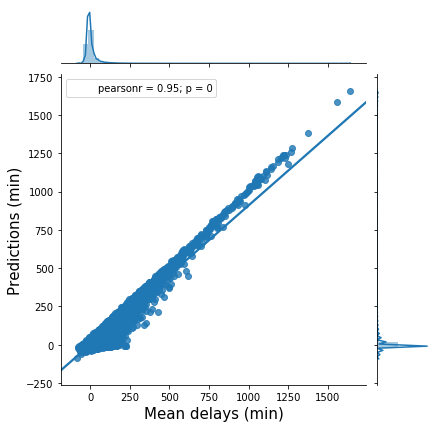

CPU times: user 2min 7s, sys: 19.5 s, total: 2min 26s
Wall time: 44.5 s


In [73]:
%%time
dec = df_all.loc[df_all['MONTH']==12]
sns.jointplot(x='ARRIVAL_DELAY', y='PREDICTED_DELAY', data=dec,kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.show()